In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-07 18:55:19 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=model.epi.value)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=model.epi.value*len(model.TRAY_total))
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=model.epi.value*len(model.TRAY_total))
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1),initialize=1e-20)
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1),initialize=1e-20)

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma)) 
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw to DDF

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

# Transfer from original reflux to DDF

In [13]:
check_DOF(pe,model)

Active Equality Constraints:	 29862
Active Inequality Constraints:	 21
Active Variables:		 33597
Fixed Variables:		 3662
DOF:				 73


### Transfer fixed side-draw variables

In [14]:
model.condenser.PR_L.pprint()

PR_L : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :  0.05 :     1 :  True :  True : NonNegativeReals


In [15]:
model.rho_tray = pe.Param(initialize=0.1,mutable=True)
model.sigma_reflux = pe.Param(initialize=0.5,mutable=True)
model.N_reflux_tray = pe.Var(within=pe.NonNegativeReals,bounds=(1,7),initialize=1) # bounded by upper section non-reactive trays

In [16]:
model.del_component(model.L_condenser_con)
model.del_component(model.Lx_condenser_con)
model.del_component(model.Lh_condenser_con)

def L_condenser_rule(model,j):
#     return model.reactive[j].L['R'] == model.epi + (model.condenser.L['out'] - model.epi*len(model.TRAY)) * \
#             pe.exp(-(model.TRAY_total.ord(str(j))-1-model.N_reflux_tray)**2/model.sigma_reflux) / \
#             sum(pe.exp(-(model.TRAY_total.ord(str(j_))-1-model.N_reflux_tray)**2/model.sigma_reflux) for j_ in model.TRAY)
    return pe.log(model.scale_epi + (model.reactive[j].L['R'] - model.epi)*sum(pe.exp(-(model.TRAY_total.ord(str(j_))-1-model.N_reflux_tray)**2\
            /model.sigma_reflux) for j_ in model.TRAY)) == pe.log(model.scale_epi + (model.condenser.L['out'] - model.epi*len(model.TRAY)) * \
            pe.exp(-(model.TRAY_total.ord(str(j))-1-model.N_reflux_tray)**2/model.sigma_reflux)) 
model.L_condenser_con = pe.Constraint(model.TRAY,rule=L_condenser_rule)

def Lx_condenser_rule(model,j,i):
    return model.reactive[j].x_['R',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model,j):
    return model.reactive[j].H_L_['R'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(model.TRAY,rule=Lh_condenser_rule)

### Initialized newly created value

In [17]:
model.reactive[model.TRAY.first()].L['in'].fix(0)
for i in m.COMP_TOTAL:
    model.reactive[model.TRAY.first()].x_['in',i].fix(0)
model.reactive[model.TRAY.first()].H_L_['in'].fix(0)

for j in model.reactive:
    model.reactive[j].L['R'].unfix(); model.reactive[j].L['R'].setlb(model.epi.value); model.reactive[j].L['R'].set_value(1.1*model.epi.value)
    for i in m.COMP_TOTAL:
        model.reactive[j].x_['R',i].unfix(); model.reactive[j].x_['R',i].set_value(model.condenser.x[i].value)
    model.reactive[j].H_L_['R'].unfix(); model.reactive[j].H_L_['R'].set_value(model.condenser.H_L.value)
    
model.N_reflux_tray.fix(1)
model.reactive[1].L['R'].set_value(model.condenser.L['out'].value)

In [18]:
check_DOF(pe,model)

Active Equality Constraints:	 31401
Active Inequality Constraints:	 21
Active Variables:		 33598
Fixed Variables:		 2124
DOF:				 73


### Initialize

In [19]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [20]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [21]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [22]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [23]:
model.scale_epi = 10

In [24]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

In [25]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6482  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.9  0.000       0.000  0.000  0.000  0.000       5.7751  0.5706  0.6609  0.0000       20.000
NON--[2]     130.8  0.000       0.000  0.000  0.000  0.000       5.8655  0.0772  0.6859  0.0000       20.000
NON--[3]     140.9  0.000       0.000  0.000  0.000  0.000       5.8133  0.0002  0.6192  0.0023       20.000
NON--[4]     149.8  0.000       0.000  0.000  0.000  

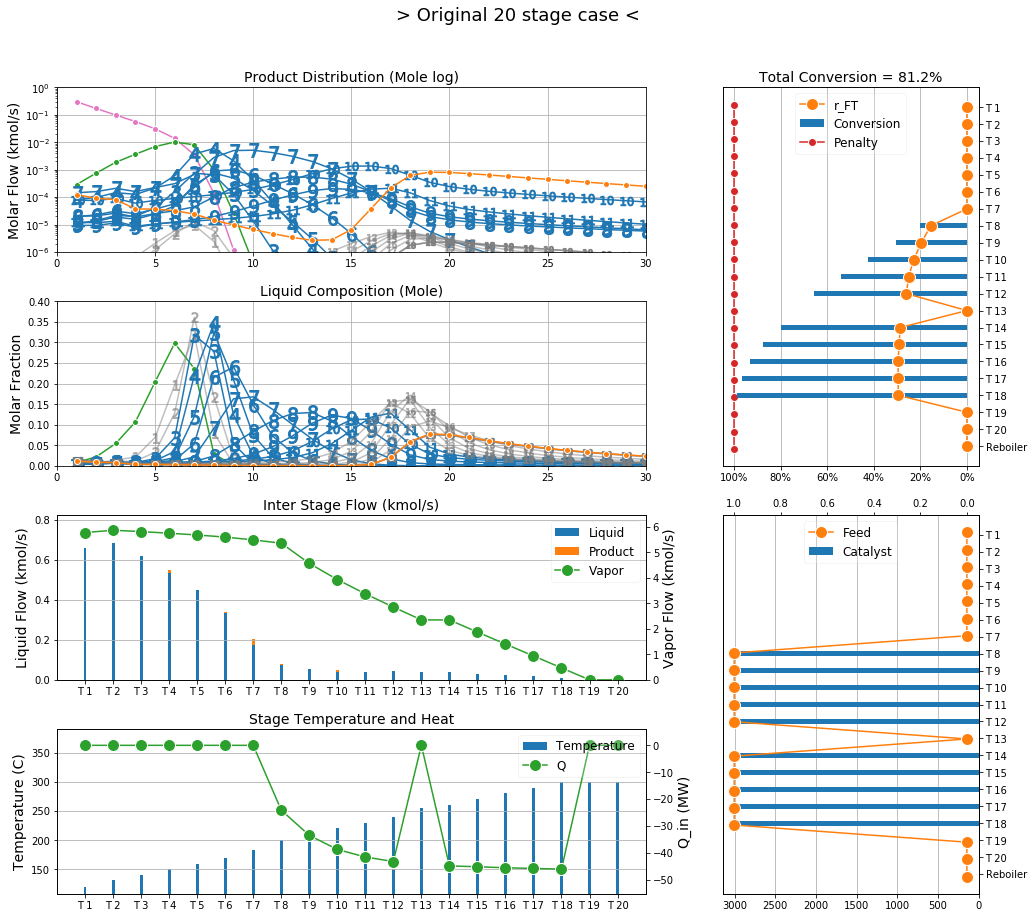

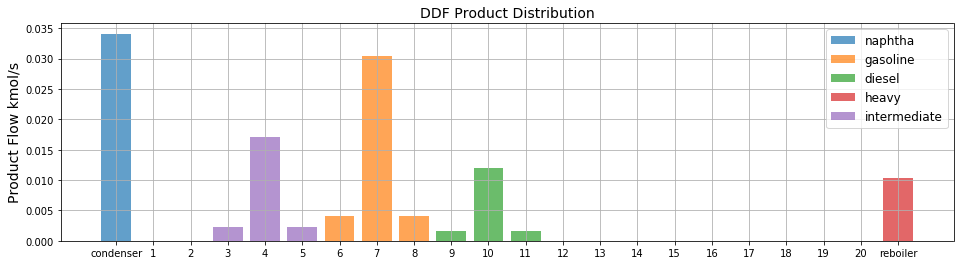

In [26]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [27]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [28]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [29]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [30]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.0061519e-01 3.76e-01 1.36e-01  -6.0 1.44e+02  -8.4 1.00e+00 1.00e+00h  1
  66 -1.0097461e-01 9.48e-01 6.07e-01  -6.0 2.30e+02  -8.8 1.00e+00 1.00e+00h  1
  67 -1.0112063e-01 6.73e-01 5.71e+00  -6.0 3.15e+02  -9.3 1.00e+00 3.36e-01h  1
  68 -1.0114409e-01 7.31e-01 1.28e-01  -6.0 2.04e+02  -9.8 1.00e+00 1.00e+00h  1
  69 -1.0123875e-01 2.18e-01 5.14e-01  -6.0 1.03e+02  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0139158e-01 4.38e-01 6.02e-01  -6.0 1.47e+02  -8.9 1.00e+00 1.00e+00h  1
  71 -1.0173385e-01 2.71e+00 1.83e+01  -6.0 1.21e+03    -  1.00e+00 2.85e-01h  1
  72 -1.0197204e-01 2.91e+00 3.96e+00  -6.0 3.87e+02    -  1.00e+00 1.00e+00h  1
  73 -1.0188919e-01 2.74e-01 6.05e-02  -6.0 1.09e+02  -9.4 1.00e+00 1.00e+00h  1
  74 -1.0191290e-01 7.07e-01 1.59e+01  -6.0 8.55e+02    -  1.00e+00 2.53e-01h  1
  75 -1.0191250e-01 4.25e-03 1.55e+00  -6.0 1.41e+01    -  9.07e-01 1.00e+00h  1
  76 -1.0191479e-01 3.05e-02


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.00%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1436          0.9925  0.0868       2.3267

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.6  0.000       0.000  0.000  0.000  0.000       5.5498  0.8738  1.0826  0.0000       20.000
NON--[2]     148.1  0.000       0.000  0.000  0.000  0.000       5.7587  0.1182  1.1772  0.0000       20.000
NON--[3]     160.0  0.000       0.000  0.000  0.000  0.000       5.7350  0.0003  1.1273  0.0000       20.000
NON--[4]     169.4  0.00

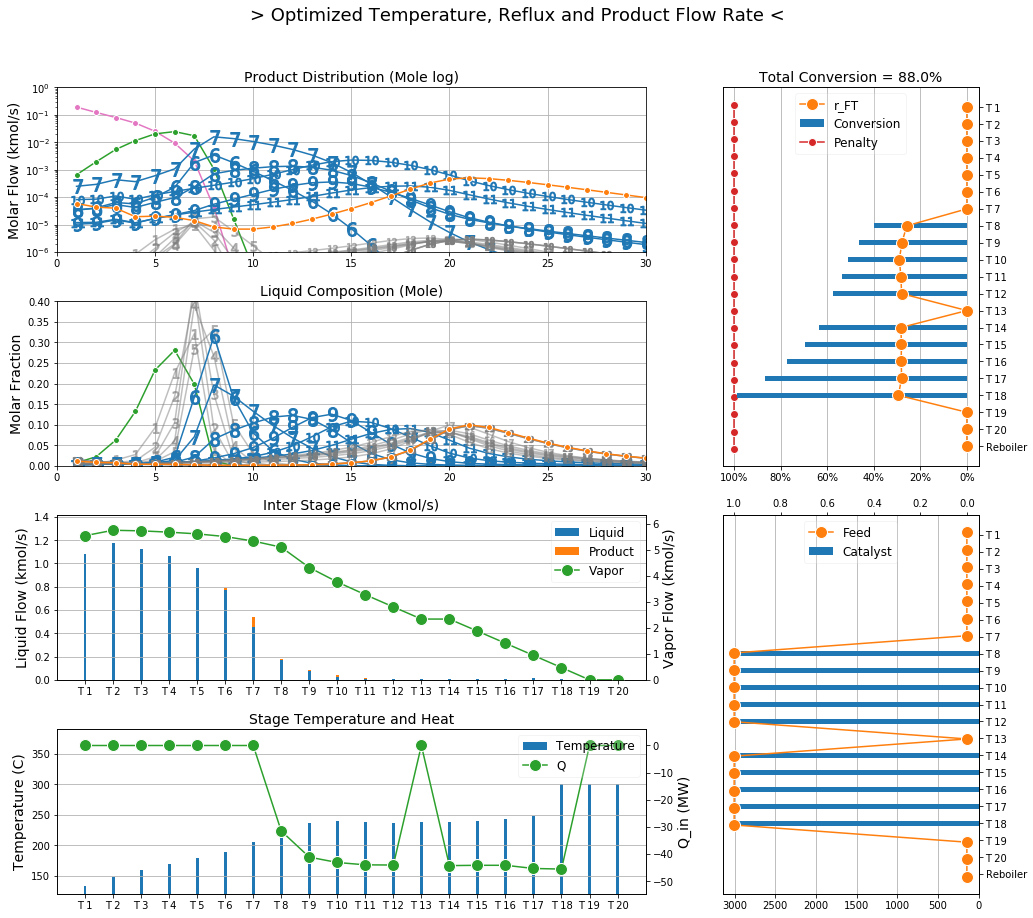

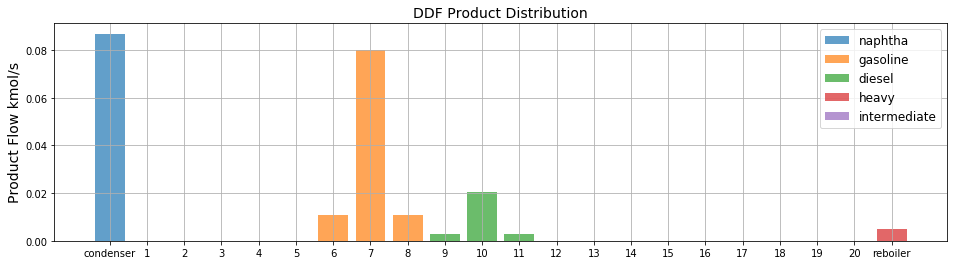

In [31]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Reflux tray location

In [32]:
model.N_reflux_tray.unfix();

In [33]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'] - model.rho_tray*\
                                (len(model.TRAY)-model.N_reflux_tray), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - rho_tray * ( 20 - N_reflux_tray ) - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [34]:
model.rho_tray = 1

In [35]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65  1.5605493e+01 1.48e+01 8.27e+03  -6.0 1.30e+03  -7.4 2.48e-01 1.48e-01h  1
  66  1.5598165e+01 1.02e+01 6.73e+03  -6.0 3.49e+02  -7.0 3.51e-01 3.32e-01h  1
  67  1.5535989e+01 4.72e+01 4.94e+03  -6.0 1.79e+03  -7.4 5.83e-01 8.19e-01h  1
  68  1.5514743e+01 4.42e+01 1.06e+04  -6.0 1.37e+04    -  9.17e-02 6.27e-02h  1
  69  1.5505276e+01 3.84e+01 1.30e+05  -6.0 1.82e+03    -  4.32e-01 2.10e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.5493135e+01 3.37e+01 1.32e+05  -6.0 2.32e+03    -  1.84e-01 1.51e-01h  1
  71  1.5484028e+01 3.03e+01 1.12e+05  -6.0 2.46e+03    -  4.85e-04 1.20e-01h  1
  72  1.5477449e+01 2.79e+01 2.13e+05  -6.0 2.97e+03    -  8.45e-03 8.07e-02h  1
  73  1.5473749e+01 2.49e+01 2.44e+05  -6.0 9.64e+02    -  5.41e-02 1.06e-01h  1
  74  1.5465776e+01 2.21e+01 1.67e+05  -6.0 2.60e+03    -  2.58e-01 1.14e-01h  1
  75  1.5461299e+01 2.03e+01 1.98e+06  -6.0 2.06e+03    -  1.00e+00 7.95e-02h  1
  76r 1.5461299e+01 2.03e+01


> rho = 1.00
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 82.95%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -142.                                        2.7553          0.7113  0.0374       2.1274

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     127.5  0.000       0.000  0.000  0.000  0.000       5.6316  0.0000  0.0000  0.0000       20.002
NON--[2]     127.5  0.000       0.000  0.000  0.000  0.000       5.6316  0.0000  0.0000  0.0000       20.001
NON--[3]     127.5  0.000       0.000  0.000  0.000  0.000       5.6316  0.0059  0.0055  0.0010       20.000
NON--[4]     127.7  0.000       0.000  0.000  0.000  0.000       

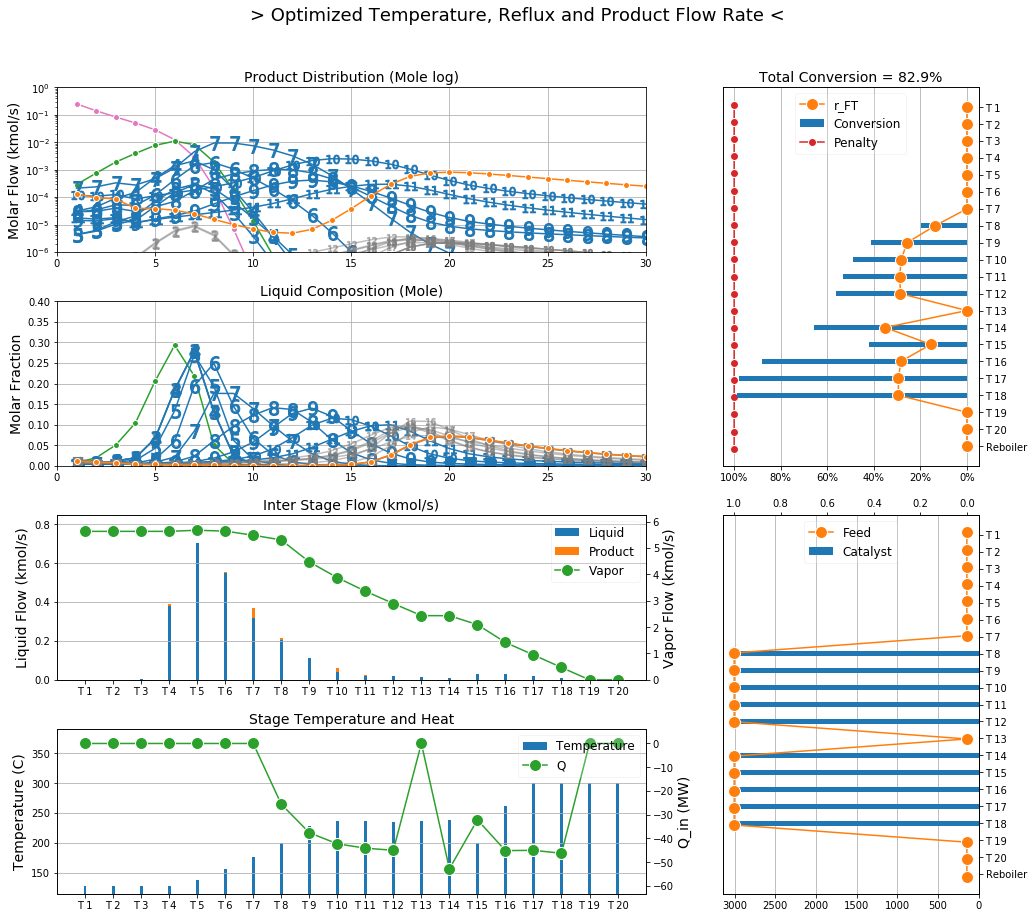

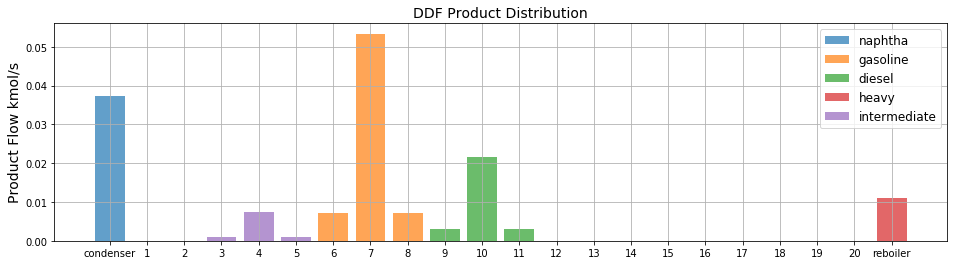

In [36]:
with HiddenLogs(log_text_dir):
    print('\n>','rho = {:.2f}'.format(model.rho_tray.value))
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [37]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)

In [38]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [39]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65  1.4643247e+01 5.28e+00 4.78e+05  -6.0 1.61e+00  -0.7 8.82e-02 2.95e-03h  1
  66  1.4643698e+01 4.80e+00 4.35e+05  -6.0 9.73e-01  -0.3 1.41e-01 8.96e-02h  1
  67  1.4644723e+01 4.40e+00 3.98e+05  -6.0 8.77e-01  -0.8 1.02e-01 8.52e-02h  1
  68  1.4662292e+01 2.96e+00 3.07e+06  -6.0 3.85e+00  -1.3 6.87e-02 3.26e-01h  1
  69  1.4661905e+01 2.91e+00 3.01e+06  -6.0 9.63e-01  -1.7 3.27e-01 1.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.4657489e+01 5.49e-01 7.21e+05  -6.0 5.41e-01  -1.3 1.08e-01 8.10e-01f  1
  71  1.4656432e+01 5.05e-01 6.64e+05  -6.0 6.44e-01  -1.8 8.63e-02 7.90e-02h  1
  72  1.4656082e+01 4.95e-01 6.50e+05  -6.0 9.27e-01  -2.3 2.09e-01 2.08e-02h  1
  73  1.4648983e+01 4.77e-01 6.26e+05  -6.0 1.32e+01  -2.7 1.73e-02 3.72e-02h  1
  74  1.4648119e+01 4.38e-01 5.75e+05  -6.0 8.50e-01  -2.3 9.01e-02 8.15e-02h  1
  75  1.4647584e+01 4.16e-01 5.46e+05  -6.0 6.43e-01  -1.9 4.11e-03 5.00e-02f  1
  76  1.4646137e+01 3.69e-01

 158  1.4325764e+01 1.06e+00 4.66e+02  -6.0 1.26e+02  -7.1 3.79e-01 1.00e+00h  1
 159  1.4320474e+01 9.37e-01 4.30e+03  -6.0 1.27e+03  -7.6 1.85e-01 1.40e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.4317444e+01 7.29e-01 3.36e+03  -6.0 4.48e+02  -8.0 1.00e+00 2.25e-01h  1
 161  1.4307432e+01 1.37e+00 3.66e+02  -6.0 2.65e+02  -7.6 7.88e-03 9.92e-01h  1
 162  1.4300486e+01 1.07e+01 2.03e+02  -6.0 1.58e+03  -8.1 6.44e-01 4.39e-01h  1
 163  1.4297053e+01 5.41e+00 1.40e+02  -6.0 3.91e+02  -7.7 1.00e+00 6.21e-01h  1
 164  1.4287104e+01 3.40e+01 8.36e+02  -6.0 2.80e+03  -8.2 2.92e-01 4.24e-01h  1
 165  1.4290306e+01 1.09e+01 2.35e+02  -6.0 5.44e+02  -8.6 1.00e+00 7.95e-01h  1
 166  1.4284321e+01 1.52e+01 3.38e+02  -6.0 1.97e+03    -  3.33e-01 2.86e-01h  1
 167  1.4284320e+01 1.40e+01 3.11e+02  -6.0 2.36e+03    -  5.19e-01 8.04e-02h  1
 168  1.4284094e+01 1.20e+01 2.66e+02  -6.0 1.03e+03    -  1.00e+00 1.43e-01h  1
 169  1.4284094e+01 1.20e+01


> Optimized Feed Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 79.40%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -130.                                        3.0144          0.6294  0.0331       1.8504

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     136.3  0.000       0.000  0.000  0.000  0.000       5.5275  0.0000  0.0000  0.0000       20.004
NON--[2]     136.3  0.000       0.000  0.000  0.000  0.000       5.5275  0.0000  0.0000  0.0000       20.002
NON--[3]     136.3  0.000       0.000  0.000  0.000  0.000       5.5275  0.0000  0.0000  0.0000       20.001
NON--[4]     136.3  0.000       0.000  0.

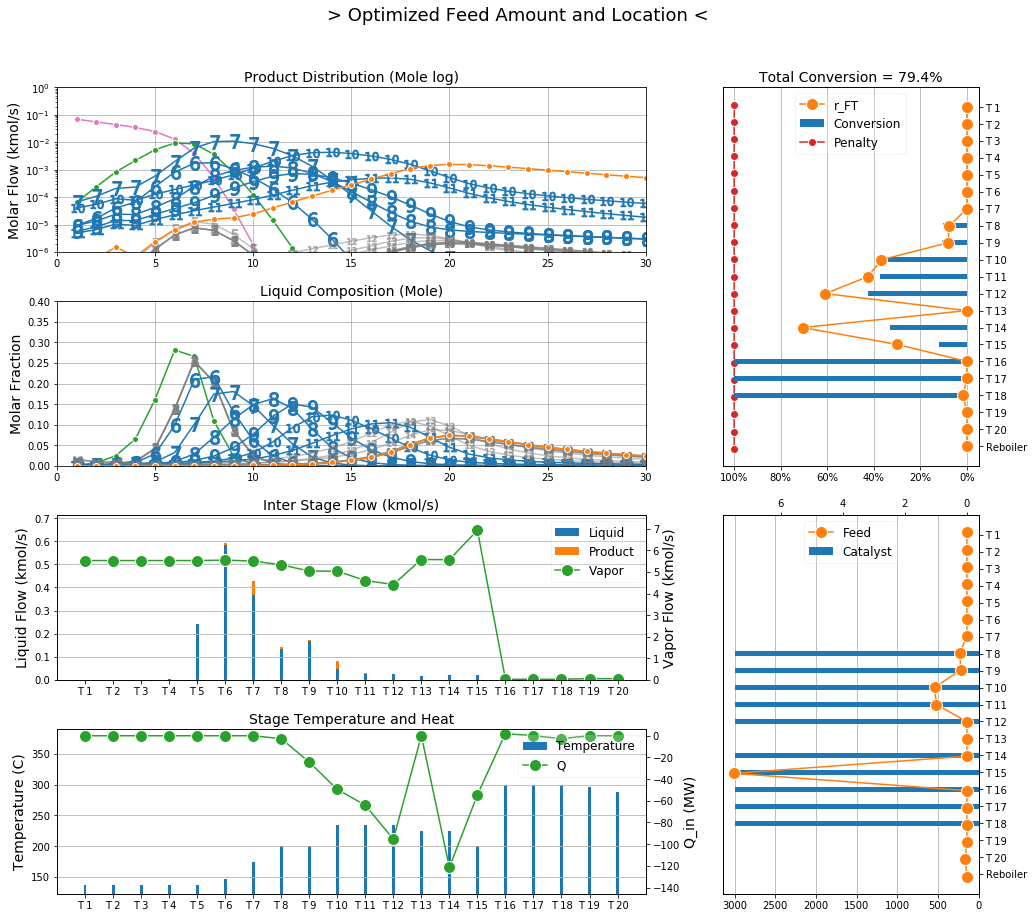

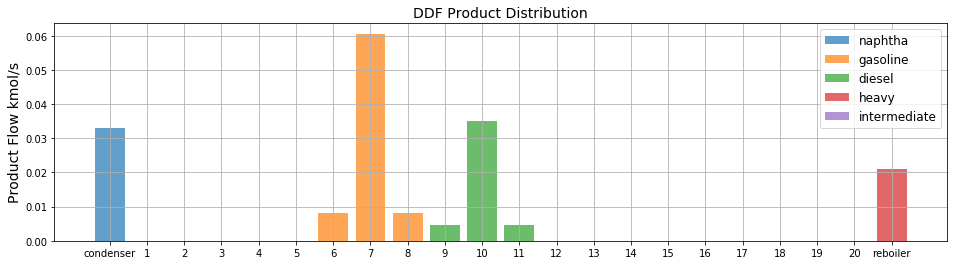

In [40]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Amount and Location')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [41]:
# for j in model.reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(10)
#     model.reactive[j].cat.setub(30000)

In [42]:
# model.total_cat_con = pe.ConstraintList()
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [43]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [44]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     check_iteration()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
# plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [45]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [46]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  63  1.4049408e+01 6.07e-01 1.33e+07  -6.0 2.18e+00    -  4.59e-05 5.23e-02h  1
  64  1.4049266e+01 5.91e-01 1.30e+07  -6.0 3.52e+00    -  3.38e-03 2.64e-02h  1
  65  1.4049098e+01 5.45e-01 1.20e+07  -6.0 2.31e+00    -  1.78e-03 7.77e-02h  1
  66  1.4049031e+01 5.26e-01 1.16e+07  -6.0 2.46e+00    -  2.29e-04 3.42e-02f  1
  67  1.4049393e+01 5.12e-01 2.68e+07  -6.0 3.57e+00    -  4.38e-06 2.75e-02h  1
  68  1.4048794e+01 4.86e-01 2.54e+07  -6.0 5.38e+00    -  4.56e-04 5.02e-02f  1
  69  1.4048748e+01 4.80e-01 2.51e+07  -6.0 2.24e+00    -  1.64e-03 1.22e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.4048743e+01 4.07e-01 2.20e+07  -6.0 2.06e+00    -  1.29e-05 1.53e-01h  1
  71  1.4048013e+01 3.95e-01 2.14e+07  -6.0 5.34e+00    -  4.93e-03 2.85e-02f  1
  72  1.4047715e+01 3.72e-01 1.99e+07  -6.0 2.26e+00    -  5.43e-04 5.90e-02h  1
  73  1.4047667e+01 3.67e-01 2.07e+07  -6.0 1.71e+00    -  4.47e-05 1.38e-02f  1
  74  1.4047941e+01 3.65e-01


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 79.84%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -141.                                        3.0017          0.8101  0.0426       1.8684

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     142.2  0.000       0.000  0.000  0.000  0.000       5.7229  0.0000  0.0000  0.0000       20.003
NON--[2]     142.2  0.000       0.000  0.000  0.000  0.000       5.7230  0.0000  0.0000  0.0000       20.002
NON--[3]     142.2  0.000       0.000  0.000  0.000  0.000       5.7230  0.0000  0.0000  0.0000       20.001
NON--[4]     142.2  0.000       0.000  0.000  0.

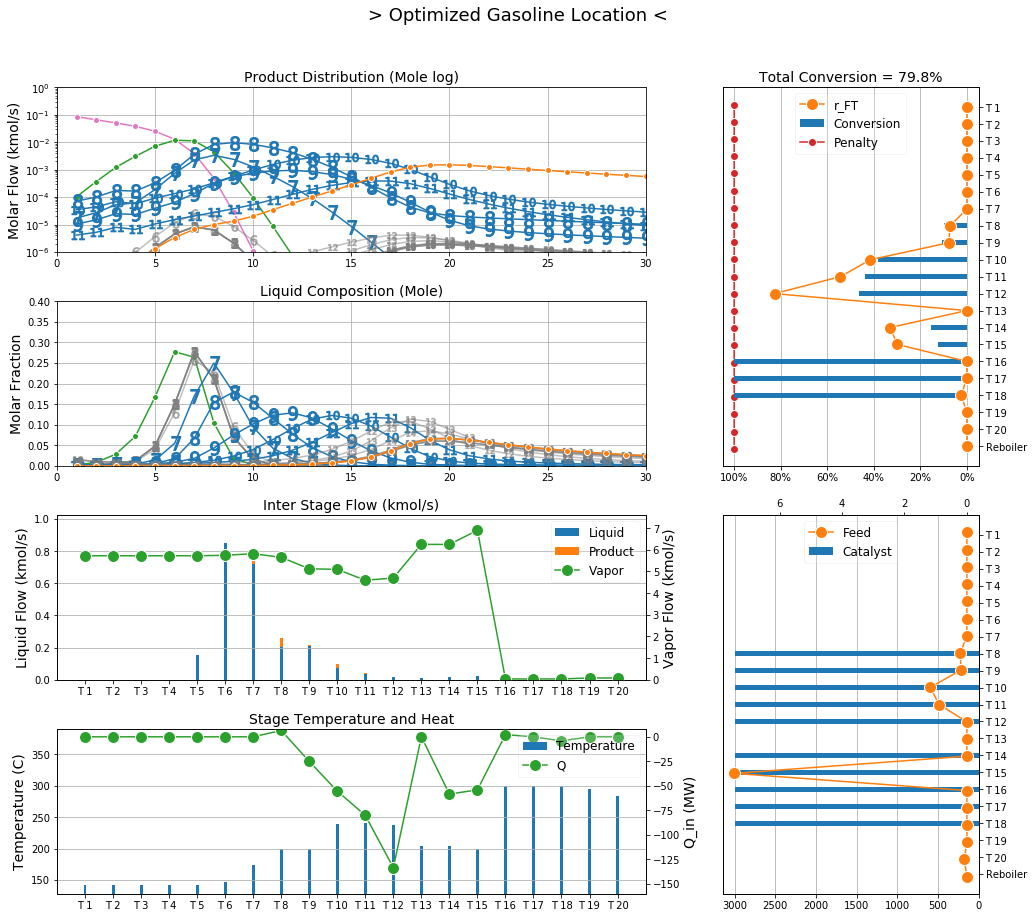

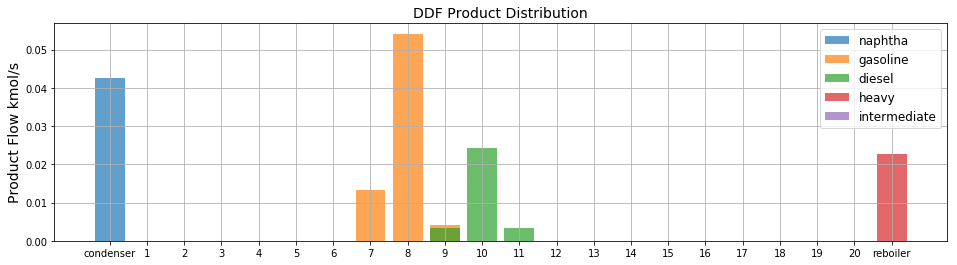

In [47]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [48]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(20)

In [49]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  62  1.3475485e+01 1.67e+00 5.79e+05  -6.0 8.21e+00    -  4.15e-02 1.08e-01h  1
  63  1.3475436e+01 1.55e+00 5.37e+05  -6.0 7.24e+00    -  2.18e-01 7.12e-02h  1
  64  1.3475405e+01 1.45e+00 5.04e+05  -6.0 6.61e+00    -  2.88e-01 6.17e-02h  1
  65  1.3475356e+01 1.16e+00 4.04e+05  -6.0 6.03e+00    -  5.05e-01 2.00e-01h  1
  66  1.3475298e+01 8.48e-01 2.94e+05  -6.0 5.18e+00    -  2.05e-01 2.72e-01h  1
  67  1.3475142e+01 3.63e-01 1.26e+05  -6.0 4.81e+00    -  1.02e-01 5.71e-01h  1
  68  1.3474736e+01 1.79e-01 6.19e+04  -6.0 2.46e+00    -  7.54e-01 5.08e-01h  1
  69  1.3474402e+01 1.54e-01 5.32e+04  -6.0 4.27e+00    -  7.30e-01 1.40e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.3471279e+01 7.57e-02 4.12e+05  -6.0 2.01e+01    -  1.15e-01 5.09e-01h  1
  71  1.3467562e+01 3.41e-02 1.72e+05  -6.0 2.54e+01    -  5.04e-01 5.55e-01h  1
  72  1.3464000e+01 3.16e-02 5.10e+04  -6.0 5.20e+01    -  7.33e-01 5.31e-01f  1
  73  1.3454071e+01 1.39e-01

 151  1.3282510e+01 6.85e+01 1.48e+03  -9.0 3.82e+03    -  3.48e-01 2.72e-01h  1
 152  1.3282507e+01 7.87e+01 1.22e+03  -9.0 7.54e+03    -  4.47e-02 1.77e-01h  1
 153  1.3282506e+01 6.44e+01 9.24e+02  -9.0 2.41e+03    -  3.88e-01 2.42e-01h  1
 154  1.3282502e+01 6.01e+01 2.39e+02  -9.0 2.39e+03    -  3.70e-02 7.43e-01h  1
 155  1.3282500e+01 5.15e+01 1.93e+02  -9.0 2.30e+03    -  1.97e-01 1.91e-01h  1
 156  1.3282500e+01 4.59e+01 1.66e+02  -9.0 2.32e+03    -  2.93e-01 1.40e-01h  1
 157  1.3282496e+01 5.06e+01 3.89e+06  -9.0 2.32e+03    -  7.00e-06 6.51e-01h  1
 158  1.3282493e+01 4.09e+01 2.53e+06  -9.0 1.99e+03    -  1.82e-03 3.51e-01h  1
 159  1.3282489e+01 3.80e+01 1.36e+02  -9.0 1.50e+03    -  1.84e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.3282486e+01 4.75e+01 1.22e+02  -9.0 8.76e+03    -  1.86e-01 9.96e-02h  1
 161  1.3282480e+01 4.91e+01 1.19e+01  -9.0 1.66e+03    -  7.50e-01 9.50e-01h  1
 162  1.3282474e+01 4.18e+01


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 80.41%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -174.                                        2.7890          1.2318  0.0648       2.1004

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     150.7  0.000       0.000  0.000  0.000  0.000       6.1861  0.0000  0.0000  0.0000       20.002
NON--[2]     150.7  0.000       0.000  0.000  0.000  0.000       6.1861  0.0000  0.0000  0.0000       20.002
NON--[3]     150.7  0.000       0.000  0.000  0.000  0.000       6.1862  0.0000  0.0000  0.0000       20.001
NON--[4]     150.7  0.000       0.000  0.000  0.00

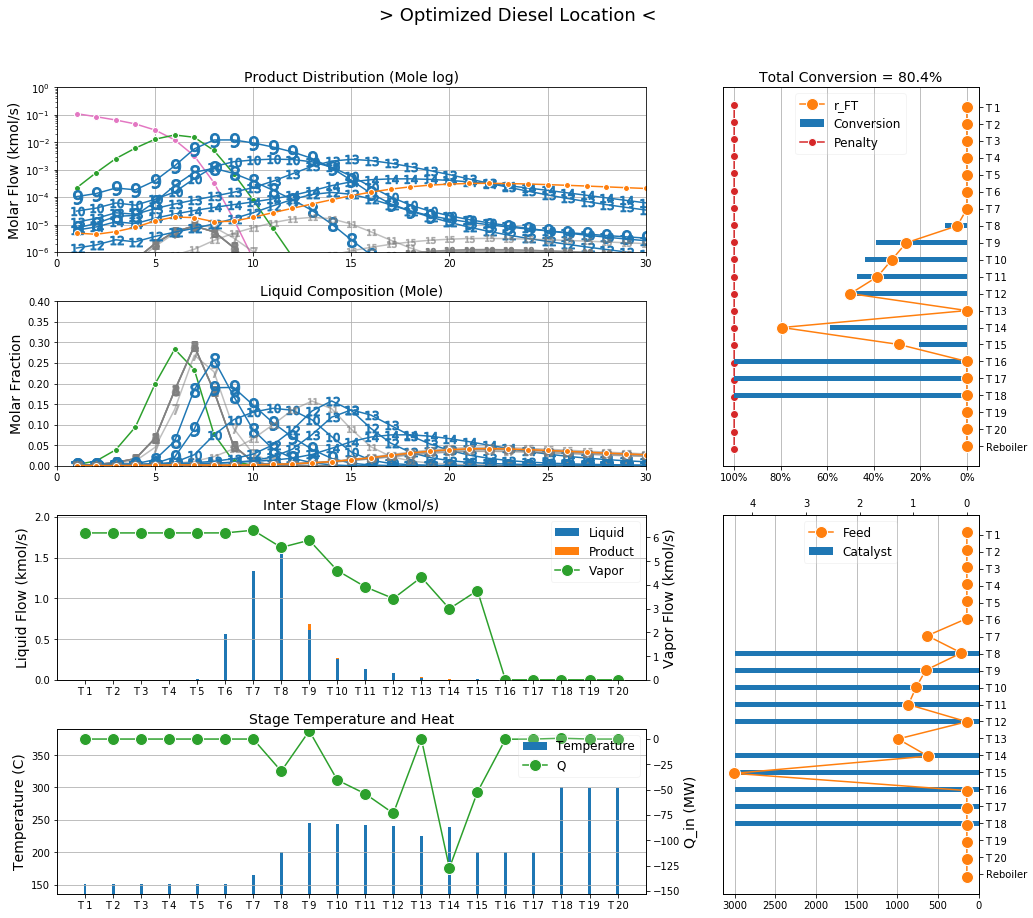

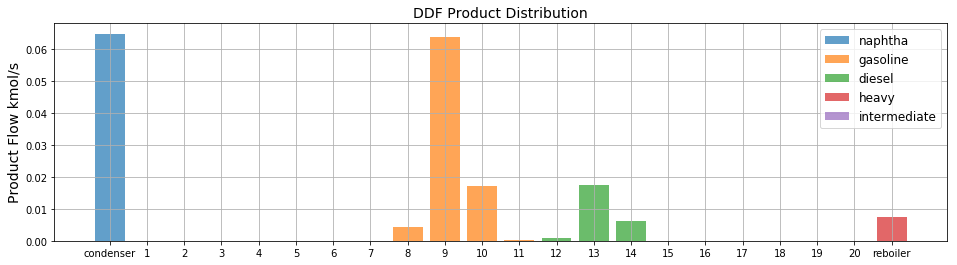

In [50]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [51]:
pdf.close()

In [52]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)